In [155]:
#Importing necessary Packages
import warnings
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from matplotlib.pylab import rcParams
%matplotlib inline

## Helper Functions

In [156]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')


def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})



# Import the check_stationarity function from previous lab
def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(TS) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

# Business Understanding

Our client is looking to purchase a home in the Miami-Dade county after recently accepting a job offer over there. The client has established that they are not looking to spend over $300,000. The client specified that their current job offer is a 3 year contract and therefore there is a reasonable possibility that they may have to relocate after 3 years. Therefore, they have approached us to identify neighborhoods that have average prices under their budget and they also want to purchase a property that would give them the highest return on investment if they were to seel their property upon rellocation in 3 years. Our task is to identify the best 5 Zip Codes which we believe will have the highest ROI after 3 years of purchase. i.e. We want the zipcodes that we believe will appreciate the most in value. These predictions will be mades using Time Series modeling.

# Data

In [157]:
#Loading our dataset
df = pd.read_csv('data/zillow_data.csv')

In [158]:
#Observing what our dataset looks like
df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


## Looking at our Miami-Dade County data

In [159]:
#Dataframe containing only zips from Miami-Dade County

miami_dade =  df[df['CountyName']=='Miami-Dade']

In [160]:
#Observing what our Miami-Dade dataset looks like

miami_dade

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
60,72463,33160,Sunny Isles Beach,FL,Miami-Fort Lauderdale,Miami-Dade,61,337300.0,337900.0,338300.0,...,1466200,1471000,1485400,1497700,1504200,1507600,1495800,1466200,1443900,1432300
84,72442,33139,Miami Beach,FL,Miami-Fort Lauderdale,Miami-Dade,85,480200.0,480700.0,481200.0,...,2917100,2925700,2942400,2958300,2946300,2912900,2900900,2923300,2933600,2914100
222,72488,33186,The Crossings,FL,Miami-Fort Lauderdale,Miami-Dade,223,120600.0,120500.0,120500.0,...,310600,311800,313700,314800,315300,317500,320700,322800,323900,324500
226,72350,33012,Hialeah,FL,Miami-Fort Lauderdale,Miami-Dade,227,118400.0,118500.0,118500.0,...,300300,302100,304500,306400,307200,308900,311400,314100,317500,320500
376,72460,33157,Village of Palmetto Bay,FL,Miami-Fort Lauderdale,Miami-Dade,377,106400.0,106600.0,106800.0,...,295600,298300,301600,304400,305900,307500,309700,312500,316400,319800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8156,72473,33170,Goulds,FL,Miami-Fort Lauderdale,Miami-Dade,8157,89500.0,89300.0,89000.0,...,247100,249700,252500,254300,254700,255800,257700,259300,261800,264400
8568,72484,33182,Tamiami,FL,Miami-Fort Lauderdale,Miami-Dade,8569,135800.0,136100.0,136300.0,...,358100,359700,361100,362100,361400,361200,362900,363500,362500,362000
10524,72461,33158,Village of Palmetto Bay,FL,Miami-Fort Lauderdale,Miami-Dade,10525,233800.0,234200.0,234500.0,...,621700,619900,618000,616500,616700,618200,618500,621900,629500,634900
10580,72495,33194,Tamiami,FL,Miami-Fort Lauderdale,Miami-Dade,10581,133200.0,132900.0,132700.0,...,319700,321900,324100,325500,325400,325700,327200,327800,327400,327000


## Number of ZipCodes for each City in the Miami-Dade County region

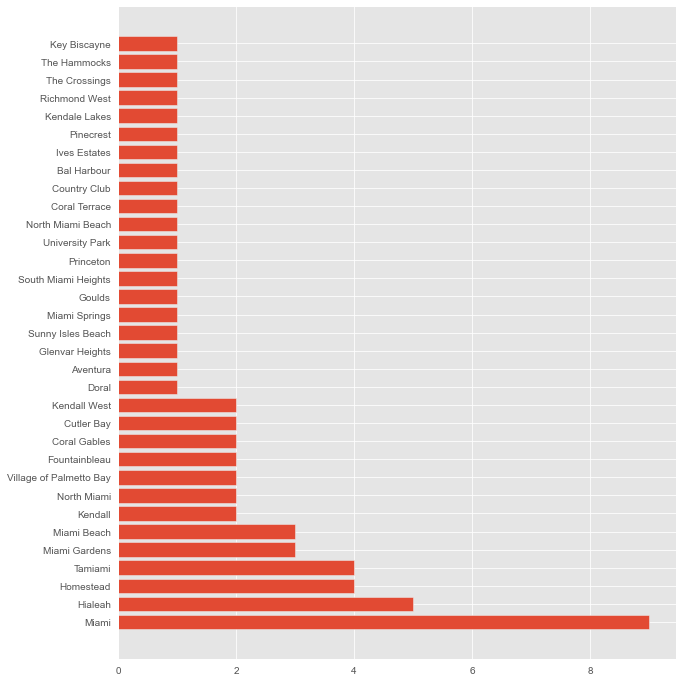

In [161]:
#Visualizing the value counts of zipcodes in each city in the Miami-Dade county

fig, ax = plt.subplots(figsize=(10,12))

y = [a for a in miami_dade['City'].value_counts()]

x = [a for a in miami_dade['City'].value_counts().keys()]

ax.barh(x,y);

We can see above that the city of Miami  has the highest number of zipcodes.

Our client has a budget of 300,000 Dollars so we want to help them purchase a property that has a price of 300,000 Dollars or less within the Miami-Dade County region.

In [162]:
miami_budget = miami_dade[miami_dade['2018-04']<=300000]

## Selecting a ZipCode to build our Time Series model on

We want to build a Time Series model to predict the future ROI for each zip code in Miami-Dade County that would fit our client's budget. But first, we will select one specific zipcode to build our time series model on. For this purpose, we decided to find the zipcode that has seen the highest growth in the 3 years since our last recorded date - April, 2018.

In [163]:
#Creating a new column that shows the 3 year increase in value. From April, 2015 to April, 2018.
warnings.filterwarnings('ignore')

miami_budget['3_yr_ROI'] = None
miami_budget['3_yr_ROI'] = miami_budget['2018-04'].apply(lambda x : x-miami_budget['2015-04'])

In [164]:
#Identifying the ZipCode that grew the most between April,2015 and April,2018.

roi_df = miami_budget[['RegionName','3_yr_ROI']].sort_values('3_yr_ROI',ascending = False)

print(f'Highest growing Zipcode since April 2015 is : {int(roi_df.iloc[0][0])}')

Highest growing Zipcode since April 2015 is : 33126


We will run our first Time Series model on the ZipCode- 33126 to predict what its future value will be. Then we can run a similar model on other zipcodes in the state to identify which 5 zipcodes have the highest predicted ROI.

In [165]:
#Dataframe containining historical prices of the 33126 Zip Code.

zip33126 = df[df['RegionName']==33126]

In [166]:
# Time Series dataframe of 33126 Zip Code prices

series33126 = melt_data(zip33126)

In [167]:
#Observing our Time Series dataframe

series33126

,value
time,
1996-04-01,108600.0
1996-05-01,108800.0
1996-06-01,109100.0
1996-07-01,109400.0
1996-08-01,109700.0
...,...
2017-12-01,294300.0
2018-01-01,295700.0
2018-02-01,296900.0


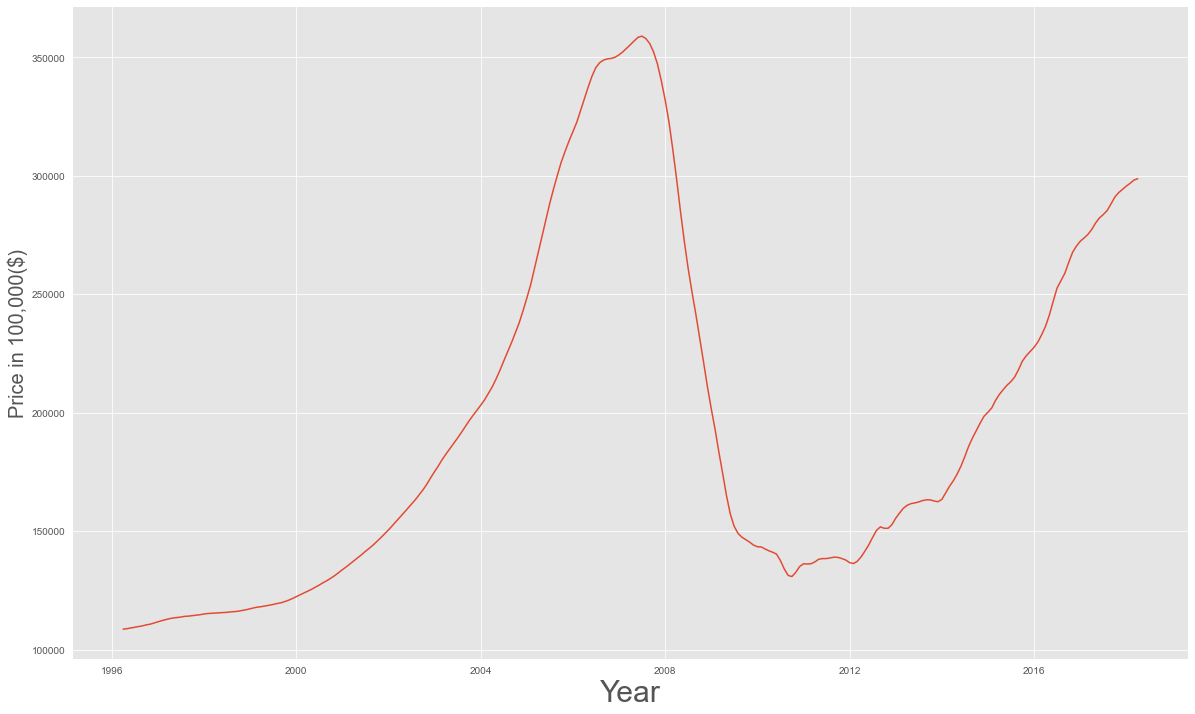

In [168]:
#Visualizing our Time Series Data for zipcode- 33126

fig, ax = plt.subplots(figsize=(20,12))
ax.plot(series33126)

ax.set_xlabel('Year', fontsize=30)
ax.set_ylabel('Price in 100,000($)',fontsize=20);

We can see from above that after several years of growth in the early years of the 21st Century, prices seemed to have likely fallen due to the economic crisis that emerged in 2008. Since around 2011 though, there has been an increase in prices but it is still yet to reach the average price level of its pre-recession peak.

We find that market conditions before the 2010s do not necessarily reflect the state of today's market. Therefore we chose to concentrate on modeling our Time Series only based on information from 2011.

In [169]:
recent_series = series33126['2011':]

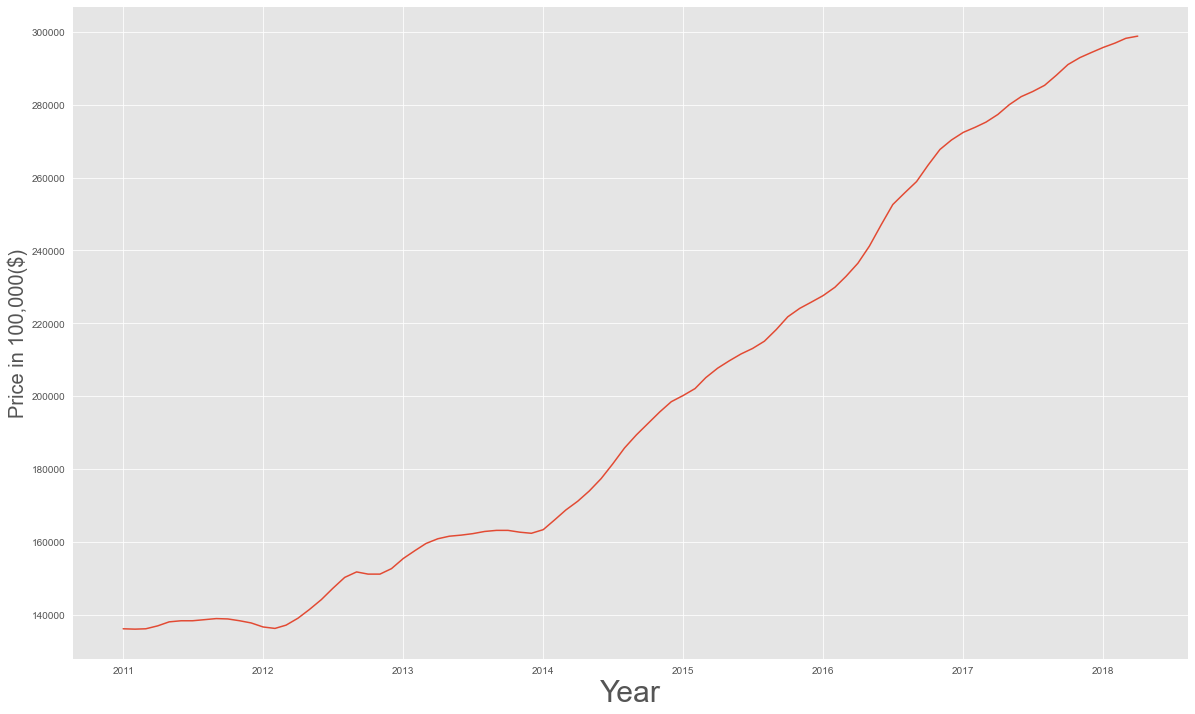

In [170]:
#Visualizing our Time Series Data for zipcode- 33126 from 2011

fig, ax = plt.subplots(figsize=(20,12))
ax.plot(recent_series)

ax.set_xlabel('Year', fontsize=30)
ax.set_ylabel('Price in 100,000($)',fontsize=20);

We can now see a positive trend that displays a somewhat linear growth rate in average price.

## Creating Some Dataframes for Our Visualizations

In [171]:
# Creating a new column that shows the 7 year increase in value. From April, 2011 to April, 2018 for visualizations. 
miami_budget['7_yr_ROI_pct'] = None
miami_budget['7_yr_ROI_pct'] = miami_budget['2018-04'].apply(lambda x : (x-miami_budget['2011-01']) / (miami_budget['2011-01']))

In [172]:
roi_7_yr = miami_budget[['RegionName', '7_yr_ROI_pct']].sort_values('7_yr_ROI_pct', ascending=False)
print(f'Highest growing Zipcode since April 2011 is : {int(roi_7_yr.iloc[0][0])}')

Highest growing Zipcode since April 2011 is : 33126


In [173]:
# Creating dataframes containing historical prices of the Top 5 Zip Codes
zip33126 = df[df['RegionName']==33126]
zip33161 = df[df['RegionName']==33161]
zip33010 = df[df['RegionName']==33010]
zip33125 = df[df['RegionName']==33125]
zip33177 = df[df['RegionName']==33177]

In [174]:
# Time Series dataframe of Top 5 Zip Code prices
series33126 = melt_data(zip33126)
series33161 = melt_data(zip33161)
series33010 = melt_data(zip33010)
series33125 = melt_data(zip33125)
series33177 = melt_data(zip33177)

In [175]:
# Creating dataframes containing historical prices of the Top 5 Zip Codes
roi33126 = roi_df[roi_df['RegionName']==33126]
roi33161 = roi_df[roi_df['RegionName']==33161]
roi33010 = roi_df[roi_df['RegionName']==33010]
roi33125 = roi_df[roi_df['RegionName']==33125]
roi33177 = roi_df[roi_df['RegionName']==33177]

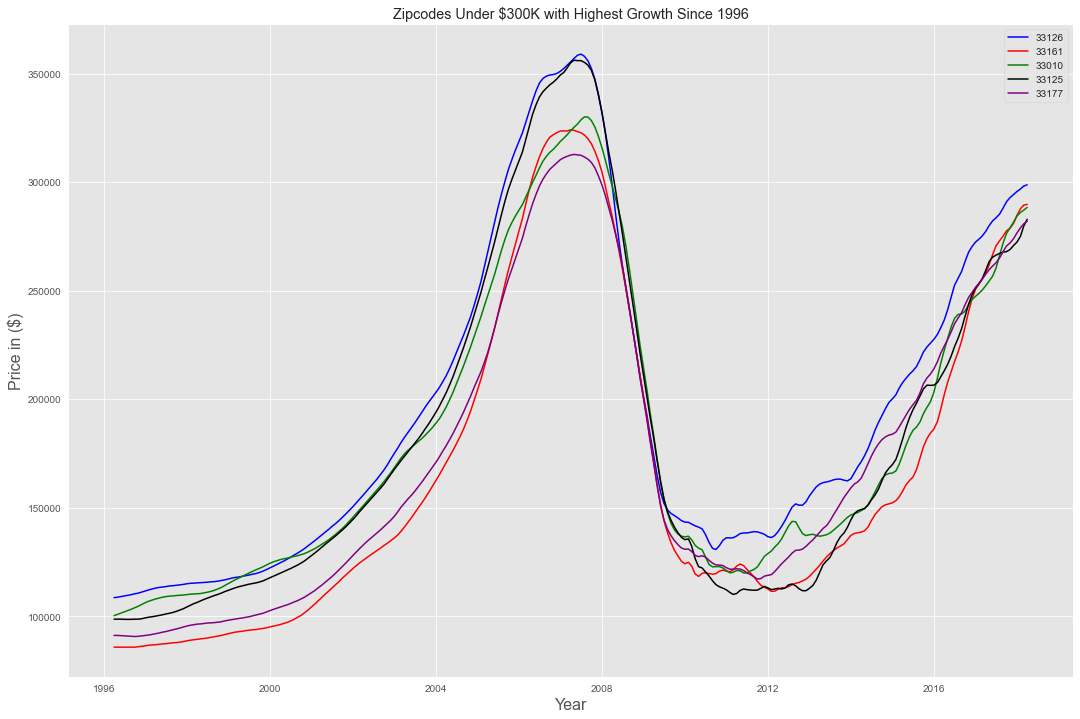

In [176]:
fig = plt.figure(figsize=(18,12))
No_1 = plt.plot(series33126, color='blue', label='33126')
No_2 = plt.plot(series33161, color='red', label='33161')
No_3 = plt.plot(series33010, color='green', label='33010')
No_4 = plt.plot(series33125, color='black', label='33125')
No_5 = plt.plot(series33177, color='purple', label='33177')
plt.legend(loc='best')
ax.set(facecolor="white")
plt.title('Zipcodes Under $300K with Highest Growth Since 1996')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Price in ($)',fontsize=16);
plt.show(block=False);

In [191]:
roi_7_yr = roi_7_yr.sort_values(by=['7_yr_ROI_pct'], ascending=False)

In [193]:
roi_7_yr

,RegionName,7_yr_ROI_pct
1176,33126,1.663102
1233,33161,1.582888
2062,33010,1.570410
838,33125,1.521390
1398,33177,1.513369
5090,33189,1.502674
8156,33170,1.356506
2458,33162,1.346702
7663,33190,1.286988
2869,33055,1.257576


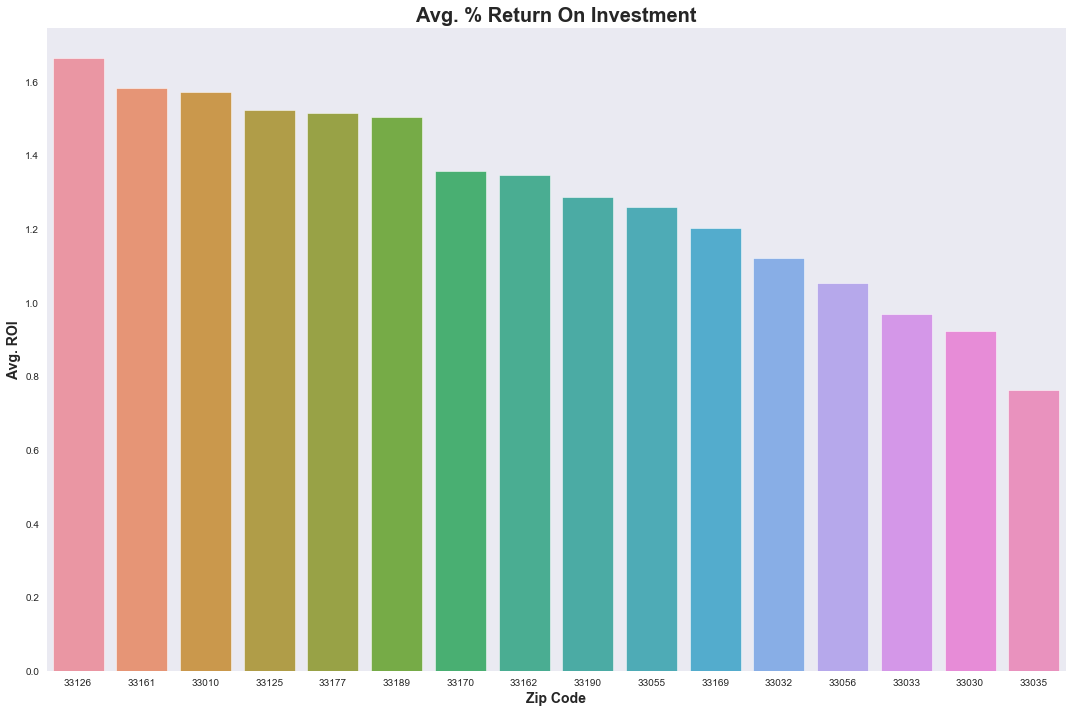

In [195]:
fig = plt.figure(figsize=(15,10))
ax = sns.barplot(x='RegionName', y='7_yr_ROI_pct', data=roi_7_yr, order=roi_7_yr.sort_values('7_yr_ROI_pct', ascending=False).RegionName)
sns.set_style('dark')
plt.xlabel("Zip Code", fontweight='bold', size=14)
plt.ylabel("Avg. ROI", fontweight='bold', size=14)
plt.title('Avg. % Return On Investment', fontweight='bold', size=20)
plt.tight_layout();

# Modeling

Because our model of choice performs the preprocessing step of trend/seasonality removal by itself, we will simply input the raw series into our model.

## Splitting our data into Train and Test

In [18]:
# Splitting the last 24 months of our series as a test dataset.
train_series = recent_series[:'2016-04']
test_series = recent_series['2016-05':]

## Fitting an AUTO-ARIMA Model on our Training Series

We find that finding the optimal p,d & q values and then fitting an ARIMA model can be a time consuming approach especially if we want to iterate this process over every zip code in Miami. The benefit of using an AUTO-ARIMA model over an ARIMA model is that it helps eliminate the additional step of finding the optimal combination of p,d & q values and thereby it runs faster than an ARIMA model. The AUTO-ARIMA model performs this step for us and automatically plugs in the p,d & q value combination that returns the lowest AIC score.

In [19]:
import pmdarima as pm

auto_model = pm.auto_arima(train_series, start_p=0, start_q=0,
                     test='adf',
                     max_p=5, max_q=5,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)



print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1728.368, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1687.033, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1680.709, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1681.812, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1035.278, Time=0.50 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.81 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=0.55 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=1684.647, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.61 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=inf, Time=0.83 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.84 sec

Best model:  ARIMA(1,0,3)(0,0,0)[0]          
Total fit time: 5.238 seco

In [20]:
#Identifying the order values for our model
auto_model.order

(1, 0, 3)

In [21]:
#Identifying the Seasonal Order values for our model
auto_model.seasonal_order

(0, 0, 0, 0)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0102      0.002    461.500      0.000       1.006       1.015
ma.L1          1.5669      0.173      9.055      0.000       1.228       1.906
ma.L2          1.1230      0.252      4.453      0.000       0.629       1.617
ma.L3          0.2647      0.172      1.539      0.124      -0.072       0.602
sigma2      3.637e+05    1.4e-07   2.59e+12      0.000    3.64e+05    3.64e+05


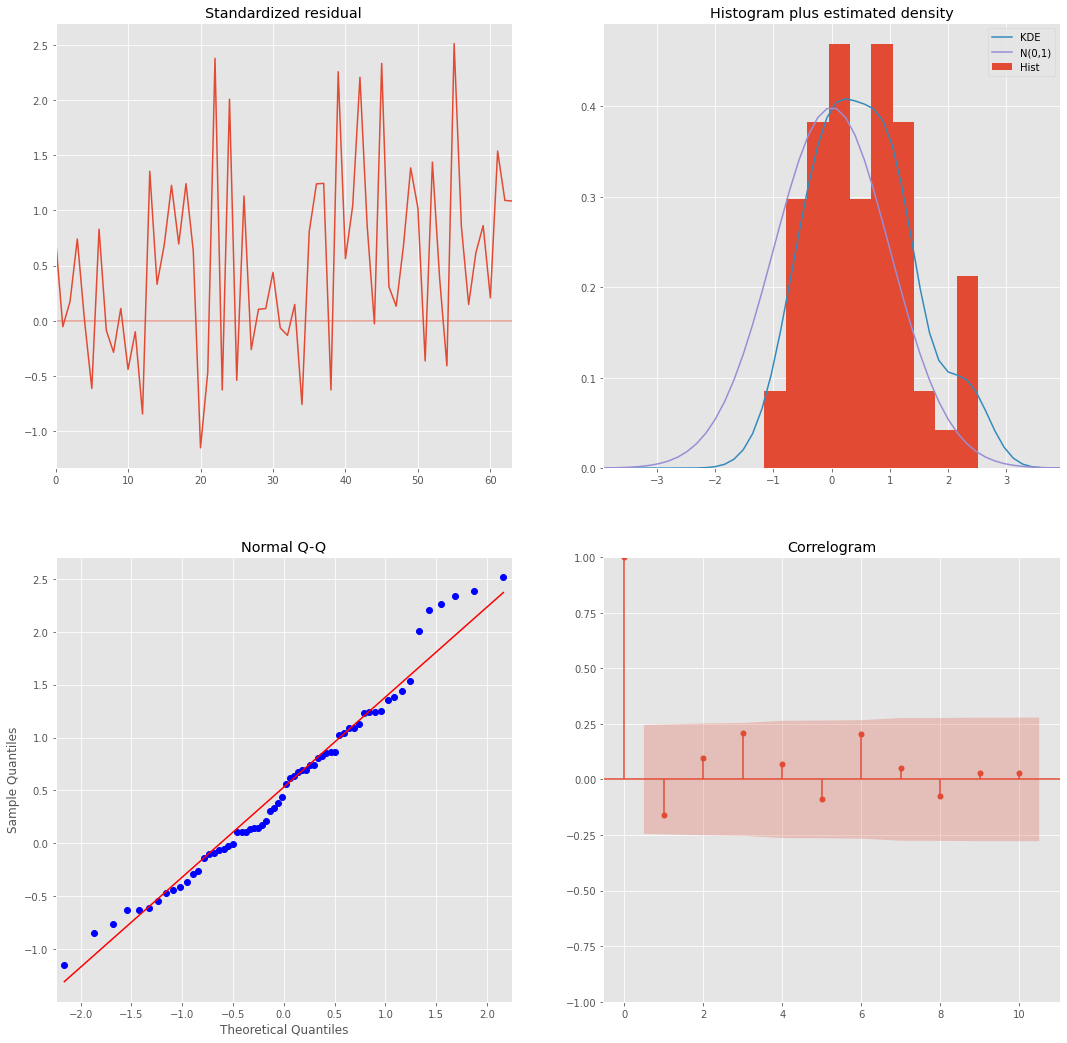

In [22]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(train_series, 
                                        order=(1,0,3), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

We want to ensure that our residuals are uncorrelated, normally distributed and have zero mean. If not, we need to tweak our model further.

Let's check for these assumptions from diagnostics plots.

* Top-right plot - ????????????

* Our qq-plot shown on the bottom left displays that our residuals are somewhat following the linear trend line. This tells us that the residuals seen here are normally distributed.

* The autocorrelation plot on the bottom right, shows that the time series residuals have low correlation with lagged versions of itself.

????? These observations lead us to conclude that our model has no correlations and provides a satisfactory fit to help forecast future values.

In [23]:
# Get predictions starting from 04-01-2015 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2016-05'), end=pd.to_datetime('2018-04'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf

,lower value,upper value
2016-05-01,238782.632383,241146.759996
2016-06-01,239622.132300,246157.519806
2016-07-01,239976.013011,250945.571581
2016-08-01,240711.164686,255239.776193
2016-09-01,241802.432446,259229.389089
2016-10-01,243104.595623,263060.158789
2016-11-01,244554.245181,266796.027590
2016-12-01,246117.059965,270471.855371
2017-01-01,247772.062175,274109.164176
2017-02-01,249505.376021,277722.379611


## Testing our model performance

Now that we have received predictions for our training data, let us plot it against our test data to see how well our model can predict the next 24 months.

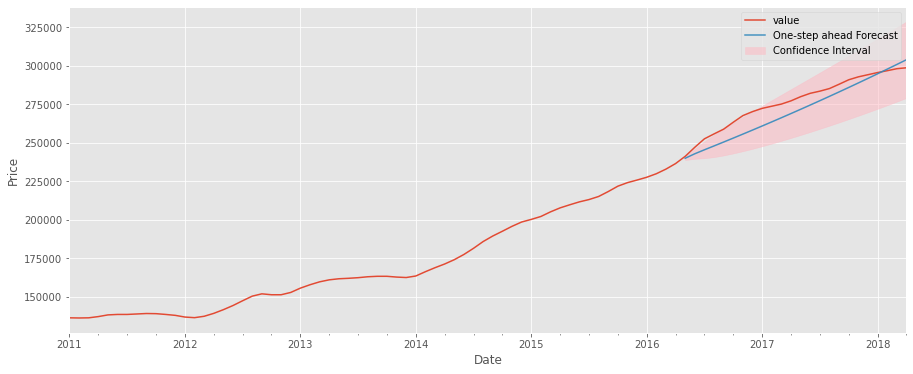

In [24]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = recent_series.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='lightpink', alpha=0.5,label = 'Confidence Interval')

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()

plt.show()

Our model was not perfectly accurate but it was able to capture the overall trend that truly occurred between April, 2016 and April, 2018. We can see now how our model would forecast the future until April, 2021- the point at which we will have reached 3 years from the purchase date of April, 2018.

In [25]:
## Getting a forecast for the next 72 months after the last recorded date on our training series.
forecast = output.get_forecast(72)
prediction = forecast.conf_int()
prediction['value'] = forecast.predicted_mean
prediction.columns = ['lower','upper','prediction'] 
prediction

,lower,upper,prediction
2016-05-01,238782.632383,241146.759996,239964.696189
2016-06-01,239622.132300,246157.519806,242889.826053
2016-07-01,239976.013011,250945.571581,245460.792296
2016-08-01,240711.164686,255239.776193,247975.470439
2016-09-01,241802.432446,259229.389089,250515.910767
...,...,...,...
2021-12-01,420677.678865,531549.453636,476113.566251
2022-01-01,424790.730561,537191.706384,480991.218472
2022-02-01,428948.585904,542889.095889,485918.840897
2022-03-01,433151.649974,548642.240934,490896.945454


# Forecasting the Future

In [26]:
# Plug the parameter values from our Auto ARIMA model into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(recent_series, 
                                        order=(1,0,3), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
full_output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0102      0.002    461.500      0.000       1.006       1.015
ma.L1          1.5669      0.173      9.055      0.000       1.228       1.906
ma.L2          1.1230      0.252      4.453      0.000       0.629       1.617
ma.L3          0.2647      0.172      1.539      0.124      -0.072       0.602
sigma2      3.637e+05    1.4e-07   2.59e+12      0.000    3.64e+05    3.64e+05


In [27]:
## Getting a forecast for the next 36 months after the last recorded date on our dataset.
forecast = full_output.get_forecast(36)
future_prediction = forecast.conf_int()
future_prediction['value'] = forecast.predicted_mean
future_prediction.columns = ['lower','upper','prediction'] 
future_prediction

,lower,upper,prediction
2018-05-01,297721.944672,300613.616330,299167.780501
2018-06-01,296339.248869,304476.173375,300407.711122
2018-07-01,296072.591251,309687.100707,302879.845979
2018-08-01,296711.291695,314640.398360,305675.845028
2018-09-01,297772.973115,319222.336898,308497.655007
2018-10-01,299085.123575,323605.904799,311345.514187
2018-11-01,300571.576440,327867.749637,314219.663038
2018-12-01,302190.836061,332049.852440,317120.344251
2019-01-01,303917.415661,336178.189848,320047.802755
2019-02-01,305734.385318,340270.186166,323002.285742


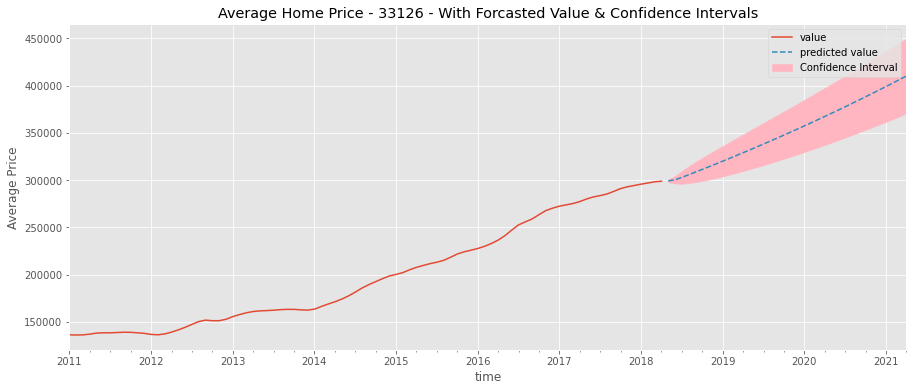

In [28]:
#Plotting our Forecast

fig, ax = plt.subplots()
recent_series.plot(ax=ax,label='Real Values')


future_prediction['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= future_prediction.index, y1= future_prediction['lower'], y2= future_prediction['upper'],color='lightpink',label='Confidence Interval')
ax.legend() 
plt.ylabel("Average Price")
plt.title('Average Home Price - 33126 - With Forcasted Value & Confidence Intervals')
plt.show()

# Modeling every Zip Code in Florida

In [29]:
#List of Zip Codes in the Miami-Fort Lauderdale metro region.
miami_budget_zips = [a for a in miami_budget['RegionName']]

In [30]:
zip_predictions = {}

for zipcode in miami_budget_zips:
    
    #Melting the time series of our given zipcode
    series = melt_data(df[df['RegionName']== zipcode])
    
    #Only taking data from 2011 onwards to more accurately reflect current market conditions
    recent_series = series['2011':]
    
    # Splitting the last 36 months of our series as a test dataset.
    train_series = recent_series[:'2016-04']
    test_series = recent_series['2016-05':]
    
    #Auto ARIMA model
    auto_model = pm.auto_arima(train_series, start_p=0, start_q=0,
                     test='adf',
                     max_p=5, max_q=5,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
   
    # Plug the optimal parameter values for our Training data into a SARIMAX model that fits our entire series.
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(recent_series, 
                                            order= auto_model.order, 
                                            seasonal_order= auto_model.seasonal_order, 
                                            enforce_stationarity=False, 
                                            enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()

    ## Getting a forecast for the next 36 months after the last absrecorded date on our dataset.
    forecast = output.get_forecast(36)
    prediction = forecast.conf_int()
    prediction['value'] = forecast.predicted_mean
    prediction.columns = ['lower','upper','prediction'] 
    
    #Adding the Zipcode's ROI to the zip_predictions dictionary
    zip_predictions[zipcode] = ((prediction['prediction'][-1]) - (series['value'][-1]))/ (series['value'][-1])
    

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1707.388, Time=0.73 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=2.67 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1666.227, Time=0.93 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=8.31 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1660.104, Time=0.72 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=3.37 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1661.342, Time=1.31 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1038.249, Time=3.88 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=1.10 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=1034.440, Time=1.03 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=1664.355, Time=0.17 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=inf, Time=0.95 sec
 ARIMA(1,0,5)(0,0,0)[0]             : AIC=inf, Time=0.98 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=1667.878, Time=0.20 sec
 ARIMA(2,0,5)(0,0,0)[0]             : AIC=inf, Time=1.02 sec
 A

In [31]:
#Looking at our 3 year ROI predictions
zip_predictions

{33125: 0.4709719854696541,
 33033: 0.5473640576842268,
 33126: 0.3727276788390636,
 33161: -1.0,
 33177: 0.4290426861576274,
 33010: 0.4654536722328192,
 33032: 0.49979218633465766,
 33169: 0.4516428225153808,
 33162: 0.5306867340258925,
 33055: 0.560958838866512,
 33056: 0.6274972837968116,
 33030: 0.5729414493201569,
 33189: 0.37965801216984685,
 33035: 0.43487782134555514,
 33190: 0.3177507838204503,
 33170: 0.4665716211951121}

In [32]:
# Sorting our 3 year ROI forecast for zipcodes into descending order
sort_orders = sorted(zip_predictions.items(), key=lambda x: x[1], reverse=True)

sorted_forecast_3yr = {}
for i in sort_orders:
	sorted_forecast_3yr[i[0]] = i[1]

In [33]:
# 3 year forecast for zipcodes arranged in descending order
sorted_forecast_3yr

{33056: 0.6274972837968116,
 33030: 0.5729414493201569,
 33055: 0.560958838866512,
 33033: 0.5473640576842268,
 33162: 0.5306867340258925,
 33032: 0.49979218633465766,
 33125: 0.4709719854696541,
 33170: 0.4665716211951121,
 33010: 0.4654536722328192,
 33169: 0.4516428225153808,
 33035: 0.43487782134555514,
 33177: 0.4290426861576274,
 33189: 0.37965801216984685,
 33126: 0.3727276788390636,
 33190: 0.3177507838204503,
 33161: -1.0}

In [34]:
#Selecting only the Top 5 Zips
top_5_zipcodes = list(sorted_forecast_3yr.items())[:5]

In [35]:
top_5_zipcodes

[(33056, 0.6274972837968116),
 (33030, 0.5729414493201569),
 (33055, 0.560958838866512),
 (33033, 0.5473640576842268),
 (33162, 0.5306867340258925)]

In [36]:
remaining_zipcodes = list(sorted_forecast_3yr.items())[5:]

In [37]:
remaining_zipcodes

[(33032, 0.49979218633465766),
 (33125, 0.4709719854696541),
 (33170, 0.4665716211951121),
 (33010, 0.4654536722328192),
 (33169, 0.4516428225153808),
 (33035, 0.43487782134555514),
 (33177, 0.4290426861576274),
 (33189, 0.37965801216984685),
 (33126, 0.3727276788390636),
 (33190, 0.3177507838204503),
 (33161, -1.0)]

In [38]:
avg_ROI_other_zips = sum([a[1] for a in remaining_zipcodes])/len(([a[1] for a in remaining_zipcodes]))

In [39]:
avg_ROI_other_zips

0.29895357000728795

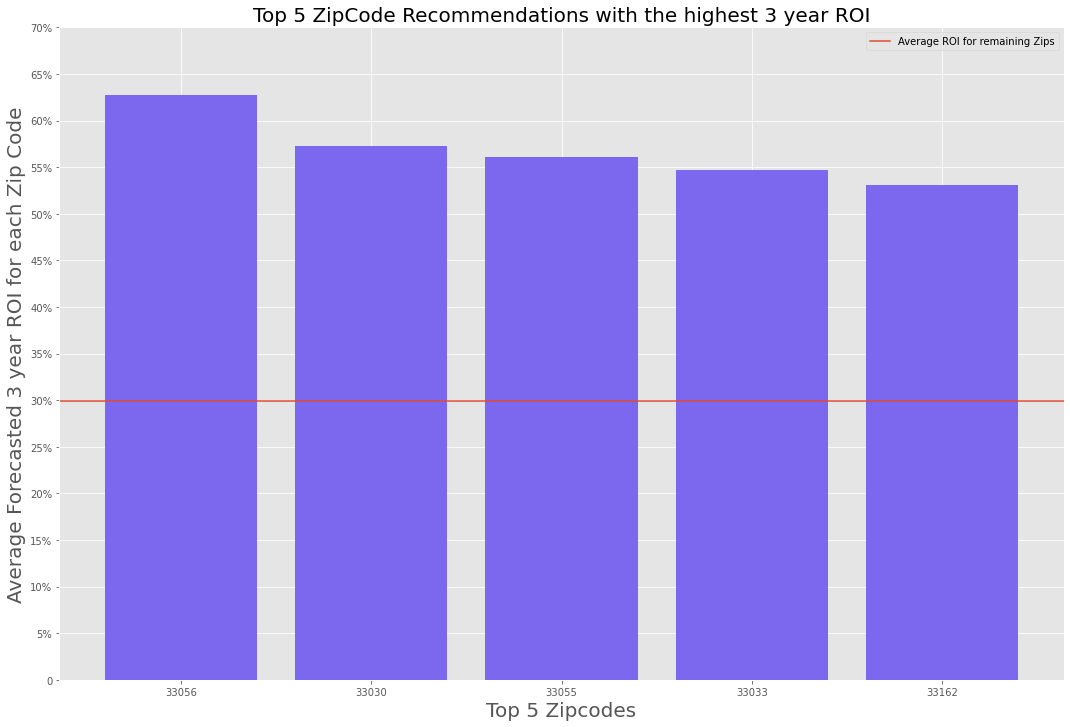

In [40]:
fig, ax = plt.subplots(figsize=(18,12))

x_labels = [top_5_zipcodes[0][0],top_5_zipcodes[1][0],top_5_zipcodes[2][0],top_5_zipcodes[3][0],top_5_zipcodes[4][0]]
x = [1,2,3,4,5]
y = [top_5_zipcodes[0][1],top_5_zipcodes[1][1],top_5_zipcodes[2][1],top_5_zipcodes[3][1],top_5_zipcodes[4][1]]

ax.bar(x, y, color='mediumslateblue')
ax.axhline(y=avg_ROI_other_zips,label = 'Average ROI for remaining Zips')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_yticks([0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7])
ax.set_yticklabels([0,'5%','10%','15%','20%','25%','30%','35%','40%','45%','50%','55%','60%','65%','70%'])
ax.set_title('Top 5 ZipCode Recommendations with the highest 3 year ROI', fontsize=20)
ax.set_ylabel('Average Forecasted 3 year ROI for each Zip Code', fontsize=20)
ax.set_xlabel('Top 5 Zipcodes',fontsize=20)
ax.legend();